#### Import Libraries

In [ ]:
import cv2 as cv
import numpy as np
import math
from google.colab import drive
from matplotlib import pyplot as plt

In [ ]:
# Accessing My Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Class: Logarithmatic Model

In [ ]:
class LograrithmaticModel:
 
    #is_log= Ture means whant to change this value to a logarithmatic scale
    def __init__(self, val , is_log = True): 
      self.real = val
      if is_log:
        self.val = 2*(val - 128)/257.
      else:
        self.val = val 
    
    def __str__(self): # overload print(LograrithmaticModel)
        return str(self.val)
  
    def __add__(self, v2): # overload V1<+>V2
        val = 0
        if isinstance(v2, LograrithmaticModel):
          val = v2.val
        else: 
          raise Exception("Error") 
        return LograrithmaticModel((self.val+val)/(1+(self.val*val)) , False)
                  
    def __sub__(self, v2): # overload v1<->v2
        val = 0
        if isinstance(v2, LograrithmaticModel):
          val = v2.val
        else:
          raise Exception("Error") 
        return LograrithmaticModel((self.val-val)/(1-(self.val*val)),False)
    
    def __mul__(self,scalar): # overload scalar <x> v
        if isinstance(scalar, LograrithmaticModel):
          raise Exception("Error")
        first  = np.power((1 + self.val), scalar )
        second = np.power((1 - self.val), scalar ) 
        return LograrithmaticModel((first-second)/(first+second), False)
        
    
    def __truediv__(self,v2): # overload true division v1/v2
        val = 0
        if isinstance(v2, LograrithmaticModel):
            val = v2.val
        else:
            val = v2
        return LograrithmaticModel( self.val / val, False)
    
    def phy(self, value):
        return 0.5 * np.log((1+value)/(1-value))
  
    def scalar_product(self,v2): # overload (v1|v2)E    
        return self.phy(self.val) * self.phy (v2.val)
        
    def norm(self): #overload ||V1||E
      return abs(self.val)
            # return abs(self.phy(self.val))
    
    def convert_to_real(self):
        return int ((self.val*257./2.)+128)
        # return self.val

## Class: Image

In [ ]:
import math
def combination(n,i): 
    return math.factorial(n)/(math.factorial(i)*math.factorial(n-i))
def qx(x ,m , i, x1):
    return combination(m , i) * (np.power(x, i) *  np.power((x1-x), m-i) ) / np.power(x1, m)
def qy(y ,n , j, y1):
    return combination(n , j) * (np.power(y, j) *  np.power((y1-y), n-j) ) / np.power(y1, n)
def pij(x , y , i , j , m , n, x1, y1):
    return  qx(x , m , i, x1 )* qy(y , n , j, y1 )
def Log_value(L): # pass array of objects 
  return np.array([[element.convert_to_real() for element in row] for row in L])
def convert_to_real(element):
  return int ((element*257./2.)+129)
  
class Image:

    def __init__(self, path, RGB=False):
        self.img_path = path 
        X = cv.imread(self.img_path)
        self.img = cv.cvtColor(X, cv.COLOR_BGR2RGB)
        self.red , self.green , self.blue = cv.split(self.img) #temp
        self.h = self.img.shape[0] # height
        self.w = self.img.shape[1] # width 
        self.actual_channels = self.img.shape[2] # number of actual channels
        self.n = 0
        self.m = 0
        self.red_log_img = self.green_log_img = self.blue_log_img = self.log_img = None
        self.RGB = RGB

        if RGB == True:
          self.num_channels = 3 # number of the required channels
          self.red_log_img = np.array( [[LograrithmaticModel(element)  for element in row] for row in self.red])
          self.green_log_img = np.array( [[LograrithmaticModel(element)  for element in row] for row in self.green])
          self.blue_log_img = np.array( [[LograrithmaticModel(element)  for element in row] for row in self.blue])
          self.log_img = ((self.red_log_img + self.green_log_img)+ self.blue_log_img)*(1./3.) 

        else:
          self.img = self.red
          self.num_channels = 1
          self.log_img = np.array( [[LograrithmaticModel(element)  for element in row] for row in self.blue]) # calculate log_img = One Logarthmic Channel

        self.psi_enh = np.zeros((self.h, self.w, self.num_channels))


    # Display two images
    def display(self, title1 = "Original", title2 = "Edited"):
      plt.subplot(121), plt.imshow(self.img, cmap = 'gray'), plt.title(title1)
      plt.xticks([]), plt.yticks([])
      if self.RGB == False:
        plt.subplot(122), plt.imshow(self.psi_enh[:,:,0], cmap='gray'), plt.title(title2)
      else:
        new_psi_enh = np.array([[[convert_to_real(element) for element in row] for row in col] for col in self.psi_enh] )
        plt.subplot(122), plt.imshow(new_psi_enh), plt.title(title2)

      plt.xticks([]), plt.yticks([])
      plt.show()        
        
    def print_(self):
        print("img :) ")
        for n in self.wins:
            for s in n :
                s.print_()

    def divide_to_windows(self , m , n, gamma=1):
        self.n = n
        self.m = m
        self.p = np.zeros(((m+1, n+1, self.h, self.w)))

        self.wins = []
        # calulate Pij(x,y)
        for i in range(0,m+1): # 0 -> m
            for j in range(0,n+1): # 0 -> n
                for x in range(self.h):
                    for y in range(self.w):  
                        self.p[i ,j ,x ,y ] = pij( x, y, i, j, m , n, self.w, self.h )
        
        # new_mat = self.p[0,0,:,:].reshape(self.h, self.w)
        # plt.imshow(new_mat, cmap='gray'), plt.title("Pij")    
        # note for One channel or Multi  Channel Only the mean and variance is different 
        for i in range(0,m+1):  # 0->m
          tmp = []
          for j in range(0,n+1) : # 0->n
            tmp.append(window(self.img , i , j , m , n , self.h , self.w, self.p, self.log_img, gamma=gamma, red_log_img = self.red_log_img, green_log_img = self.green_log_img, blue_log_img=self.blue_log_img, RGB=self.RGB))
          self.wins.append(tmp)
        
    def cal_psi_enh(self):
      # self.wins[i,j].win is a scalar
      # self.wins[i,j].psi is a logarithmatic

      self.wins = np.array(self.wins)
      for channel in range(0, self.num_channels): # 1 For One Channel # 3 For 3 Channels 
        for i in range(0,self.m+1):
          for j in range(0,self.n+1):
            for x in range(self.h):
              for y in range(self.w):
                self.psi_enh[x,y, channel] += (self.wins[i,j].psi[x,y,channel] * self.wins[i,j].win[x,y]).val

      return self.psi_enh

## Class: Window

In [ ]:
class window :
    def __init__(self,img , i , j , m , n , h , w , ps , log_img, gamma = 1, red_log_img = None, green_log_img = None, blue_log_img = None, RGB=False):
        self.win = np.zeros(( h  , w))
        self.variance = 0 
        self.m = m
        self.n = n
        self.h = h
        self.w = w
        self.i = i 
        self.j = j 
        self.gamma = gamma
        self.calc_win(img , h , w , ps)
        self.card = self.cal_card()
        self.cal_mean(log_img)
        self.cal_variance(log_img)
        if RGB == True:
          self.cal_psi_RGB(red_log_img, green_log_img, blue_log_img)
        else:
          self.cal_psi(log_img)
 
    def calc_win (self,img , h , w , ps ):
        tmp1 = np.power(ps[self.i, self.j, :, :], self.gamma)
        for x in range(h):
            for y in range(w):
              tmp2 = np.sum(np.power(ps[:, :, x, y], self.gamma))
              self.win[x,y] = tmp1[x,y] / tmp2
                
    def cal_card(self):
        return np.sum(self.win)
    
    def print_(self): #override print method
        print ("Win : "  , (self.i , self.j))
        print ("   card :" , self.card)
        print ("   Mean :" , self.mean)
        print ("   variance :" , self.variance)
        
    def cal_mean(self,log_img):
        tmp = LograrithmaticModel(0,False) 
        tmp = np.sum(log_img[:,:] * (self.win[:,:] / self.card))
        self.mean= tmp
        
    def cal_variance (self,log_img):
        num = 0
        for x in range(self.h):
            for y in range(self.w):
                num += (self.win[x,y]* np.power((log_img[x , y] - self.mean ).norm(),2))/ self.card
        self.variance =num
    
    
    def cal_psi_RGB(self, red_log_img, green_log_img, blue_log_img):
      red_psi= []
      green_psi = []
      blue_psi = []
      segma_u = 1./np.sqrt(3.)
      for x in range(self.h):
        row1 = []
        row2 = []
        row3 = []
        for y in range(self.w): 
          constant = (segma_u/np.sqrt(self.variance))
          r = (red_log_img[x,y] - self.mean) * constant
          g = (green_log_img[x,y] - self.mean) * constant
          b = (blue_log_img[x,y] - self.mean) * constant
          row1.append(r)
          row2.append(g)
          row3.append(b)

        red_psi.append(row1)
        green_psi.append(row2)
        blue_psi.append(row3)
      self.psi = np.stack([red_psi, green_psi, blue_psi], axis=2)
    
    def cal_psi(self, log_img):
      psi_= []
      segma_u = 1/np.sqrt(3.)
      for x in range(self.h):
        row = []
        for y in range(self.w): 
          g = ((log_img[x,y] - self.mean) * (segma_u/np.sqrt(self.variance)))
          row.append(g)
        psi_.append(row)

      self.psi = np.stack([psi_], axis=2)


## Application

 **Try different values for gamma (from 0 to +infinity) and notice the results.
When alpha goes bigger partitions became grisp and each window enhanced alone without making contribution to other windows.**

### Gray Image: Gamma=5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


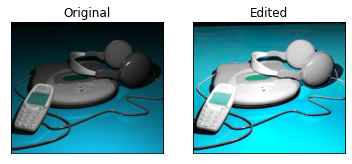

In [ ]:
image_path = "/content/drive/My Drive/FuzzyImageEnhancment/5.PNG"
img = Image(image_path, RGB=True)
img.divide_to_windows(1,1,gamma=5)
f3 = img.cal_psi_enh()

img.display()

## Gray Image: Gamma =150

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


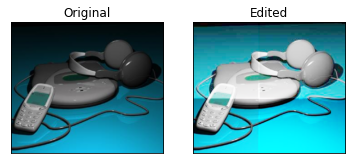

In [ ]:
image_path = "/content/drive/My Drive/FuzzyImageEnhancment/5.PNG"
img = Image(image_path, RGB=True)
img.divide_to_windows(1,1,gamma=150)
f3 = img.cal_psi_enh()

img.display()

## RGB Images: gamma=4

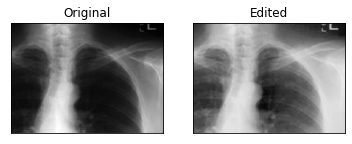

In [ ]:
image_path = "/content/drive/My Drive/FuzzyImageEnhancment/3.PNG"
img  = Image(image_path, RGB=False)
img.divide_to_windows(1,2, gamma =4)
img_psi_enh = img.cal_psi_enh()
img.display()

### Gray Image: gamma = 100

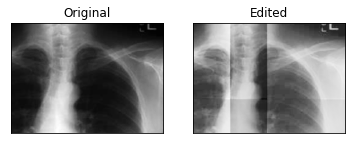

In [ ]:
image_path = "/content/drive/My Drive/FuzzyImageEnhancment/3.PNG"
img  = Image(image_path, RGB=False)
img.divide_to_windows(1,2, gamma =200)
img_psi_enh = img.cal_psi_enh()
img.display()